# SIR Model
We will model the spread of a virus by representing population groups as nodes in a graph

In [1]:
# import libraries
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pandas as pd
import pyvis
from pyvis.network import Network
from scripts.Behav import run_simulations

In [2]:
def deriv(y, t, N, beta, gamma, t_array, p_n_array):
    """ 
    Diffrential equations for the SIR model
    """
    S, I, R = y

    # current p_n value
    p_n = np.interp(t, t_array, p_n_array)

    # introduce human behavior variables
    S_effective = S * (1 - p_n) # individuals that are susceptible, after introducing vaccination
    
    dSdt = -beta * S_effective * I / N
    dIdt = beta * S_effective * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

In [3]:
def run_SIR_with_behavior(N, beta, gamma, days, initial_p_n):
    """ 
    Run SIR model over a given number of days, introducing impact of vaccination
    """
    # initial conditions
    I0 = 1
    R0 = 0
    S0 = N - I0 - R0
    t = np.linspace(0, days, days)

    # get vaccination behavior over time
    # convert from percentage to decimal
    p_n_array = np.linspace(initial_p_n, min(initial_p_n + 0.2, 1.0), len(t))

    # integrate the SIR equations over the time vector
    ret = odeint(deriv, (S0, I0, R0), t, args = (N, beta, gamma, t, p_n_array))
    return t, ret


In [4]:
def plot_SIR(t, S, I, R):
    """ 
    Linear plot of the SIR model
    """
    fig = plt.figure(figsize = (10, 8))
    ax = fig.add_subplot(111, facecolor = '#dddddd', axisbelow = True)
    ax.plot(t, S/1000, 'b', alpha=0.5, lw=2, label='Susceptible')
    ax.plot(t, I/1000, 'r', alpha=0.5, lw=2, label='Infected')
    ax.plot(t, R/1000, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
    ax.set_xlabel('Time /days')
    ax.set_ylabel('Number (1000s)')
    ax.set_title('SIR Model')
    ax.legend()
    plot = plt.show()

    return plot


SIR Model with no behavioral effects


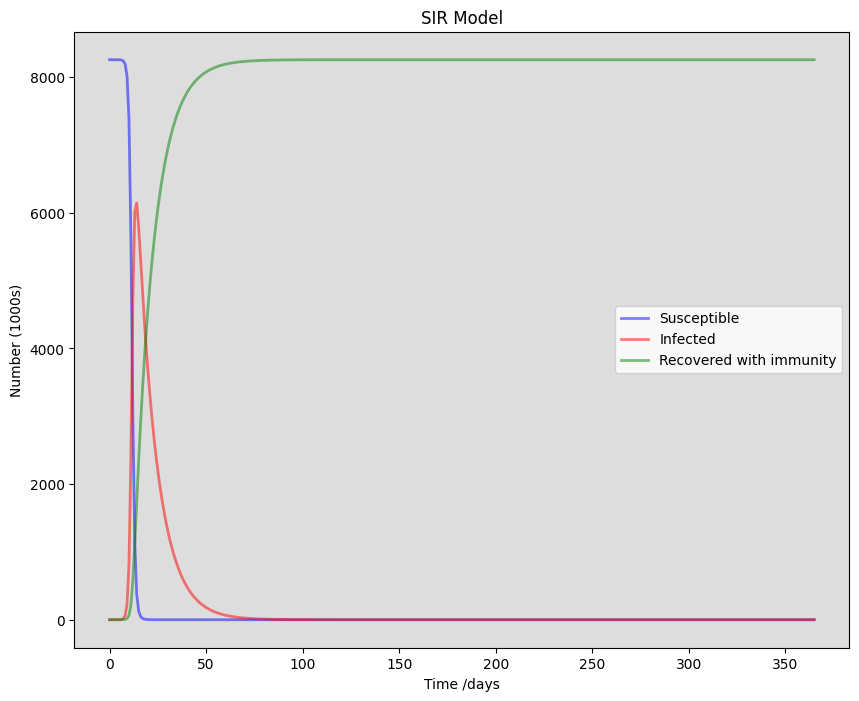

In [10]:
# initialize numbers for testing
days = 365
N = 8258000 # NYC population
beta = 1.47 # infection rate is 1.46 to 1.48 people per person
gamma = 0.1 # recovery rate

# initial conditions
I0 = 1 # infected
R0 = 0 # recovered
S0 = N - I0 - R0
t = np.linspace(0, days, days) # time vector

p_n_array = np.zeros(len(t))

# integrate the SIR equations over the time vector
ret_no_behavior = odeint(deriv, (S0, I0, R0), t, args = (N, beta, gamma, t, p_n_array))

# plot the results
print("SIR Model with no behavioral effects")
plot_SIR(t, ret_no_behavior[:,0], ret_no_behavior[:,1], ret_no_behavior[:,2])


SIR Model with behavioral effects


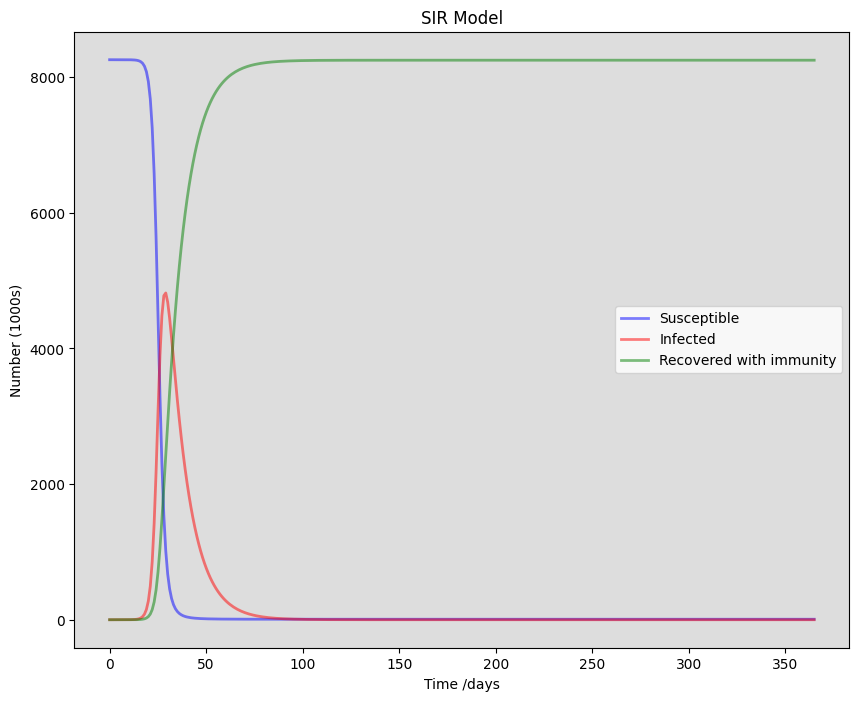

Total number of infections with behavioral effects: 82282837.30812918
Total number of infections without behavioral effects: 82353721.7566478


In [11]:
# run simulation with behavioral effects
t, ret = run_SIR_with_behavior(
    N=8258000,  # NYC population
    beta=1.47,  # infection rate
    gamma=0.1,  # recovery rate
    days=days,   # one year
    initial_p_n=0.5  # initial vaccination rate
)

print("SIR Model with behavioral effects")
plot_SIR(t, ret[:,0], ret[:,1], ret[:,2])

# quantify the impact of vaccination compared to no behavioral effects
print(f"Total number of infections with behavioral effects: {ret[:,1].sum()}")
print(f"Total number of infections without behavioral effects: {ret_no_behavior[:,1].sum()}")


### Visualize previous flu instances as a network

       Unnamed: 0       County  Year  Month     Season            Region  \
5856         5856   CHAUTAUQUA  2016     11  2016-2017           WESTERN   
9833         9833     CORTLAND  2012      5  2011-2012           CENTRAL   
22669       22669   LIVINGSTON  2013      1  2012-2013           WESTERN   
2852         2852       BROOME  2011      4  2010-2011           CENTRAL   
12917       12917         ERIE  2018     10  2018-2019           WESTERN   
26317       26317       NASSAU  2011      2  2010-2011             METRO   
4335         4335  CATTARAUGUS  2018     10  2018-2019           WESTERN   
19817       19817    JEFFERSON  2013      3  2012-2013           CENTRAL   
283           283       ALBANY  2012      4  2011-2012  CAPITAL DISTRICT   
25932       25932   MONTGOMERY  2016     12  2016-2017  CAPITAL DISTRICT   

       Week Week Ending Date                Disease  Infected  ...  \
5856     44       11/05/2016            INFLUENZA_A         1  ...   
9833     19       05/12

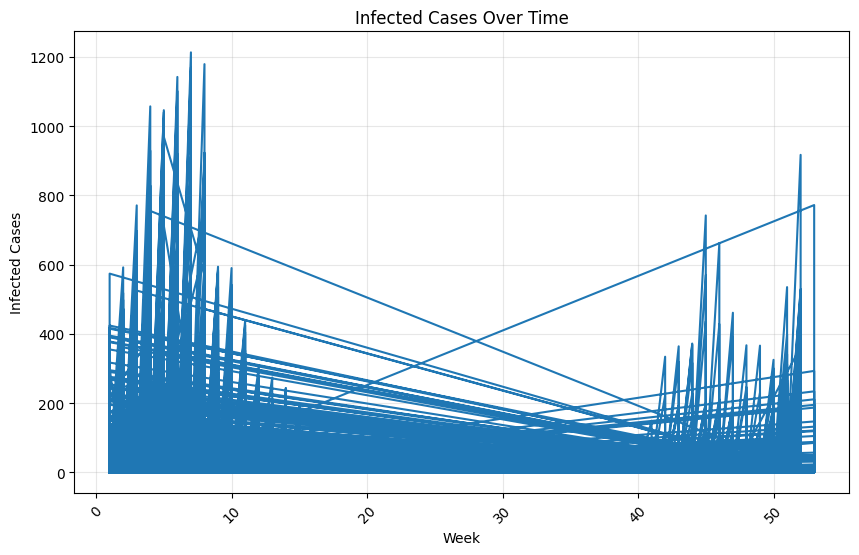

In [7]:
# import pyvis
from pyvis.network import Network
pyvis.__version__

# load and extract values from data
data = pd.read_csv('data/Influenza_NY.csv')
sample = data.sample(n = 1000, random_state = 1)
print(sample.head(10))

week = data['Week']
infected = data['Infected']


# plot the chang in infected cases over time
plt.figure(figsize=(10, 6))
plt.plot(week, infected)
plt.title('Infected Cases Over Time')
plt.xlabel('Week')
plt.ylabel('Infected Cases')
plt.xticks(rotation=45) 
plt.grid(True, alpha=0.3)
plt.show()

In [8]:
def visualize_network(sample):
    """ 
    Visualize the data in a network
    - Nodes: Counties
    - Edges: transmission across counties
    - Node size: infection counts in region
    """

    county_data = sample.groupby('County').agg({
        'Infected': 'sum', # total infected cases
        'Number_households': 'first', # number of households in county
        'Region': 'first', # region of county
    }).reset_index()

    #Visualize the data in a network
    net = Network(notebook = True, cdn_resources = "remote",
                    bgcolor = "black",
                    font_color = "white",
                    height = "750px",
                    width = "100%"
    )

    # add nodes to the network with size based on infected cases
    for _, row in county_data.iterrows():
        # normalized node size
        node_size = 10 + (row['Infected'] / county_data['Infected'].max()) * 50

        net.add_node(str(row['County']),
                    label = str(row['County']),
                    title = f"Infections: {row['Infected']}\nRegion: {row['Region']}",
                    size = node_size,
                    color = 'red' # red for infected countries
        )

    # add edges to the network
    regions = county_data.groupby('Region')
    for region, counties in regions:
        county_list = counties['County'].tolist()
        # iterate through all counties in region
        for i in range(len(county_list)):
            for j in range(i+1, len(county_list)):
                # set weight of line based on number of infected cases between counties
                weight = (counties.iloc[i]['Infected'] + counties.iloc[j]['Infected']) / 2
                net.add_edge(str(county_list[i]),
                            str(county_list[j]),
                            value = weight,
                            title = f"Regional connection: {region}")

    # configure physics for better visualization
    net.set_options("""
    {
        "physics": {
            "forceAtlas2Based": {
                "gravitationalConstant": -200,
                "centralGravity": 0.01,
                "springLength": 100,
                "springConstant": 0.01,
                "damping": 0.09
            },
            "maxVelocity": 50,
            "solver": "forceAtlas2Based",
            "timestep": 0.35,
            "stabilization": {"iterations": 150}            
        }      
    }
    """)

    net.show("network.html")

visualize_network(sample)

network.html


### Fin
We have developed a basic model on the spread of infection. We will now introduce some human behavior variables.